#### Libaries Used: 

In [1]:
%pip install roboflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:

import random
import shutil
import kagglehub
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET
from matplotlib import transforms
import math
import xml.etree.ElementTree as ET
from roboflow import Roboflow
from dotenv import load_dotenv
from ultralytics import YOLO

#### Directories

In [ ]:
ROOT_DIR = os.getcwd()
DATASET_DIR = os.path.join(ROOT_DIR, "ReNote-10")
TRAIN_IMAGE_DIR = os.path.join(DATASET_DIR, "train", "images")
TRAIN_LABEL_DIR = os.path.join(DATASET_DIR, "train", "labels")
VALID_IMAGE_DIR = os.path.join(DATASET_DIR, "valid", "images")
VALID_LABEL_DIR = os.path.join(DATASET_DIR, "valid", "labels")
ANNOTATION_PATH = os.path.join(DATASET_DIR, "data.yaml")

In [4]:
load_dotenv()
api_key = os.getenv('ROBOFLOW_KEY')

rf = Roboflow(api_key=api_key)
project = rf.workspace("receipt-dataset-awcrq").project("renote")
version = project.version(10)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
from PIL import Image

images = []

for img in os.listdir(TRAIN_IMAGE_DIR)[:200]:
        image_path = os.path.join(TRAIN_IMAGE_DIR, img)
        filename_without_extension = os.path.splitext(os.path.basename(image_path))[0]
        annotation_path = os.path.join(TRAIN_LABEL_DIR, f"{filename_without_extension}.txt")

        image = Image.open(image_path)
        
        image_data = {
                "file_path" : image_path,
                "size" : image.size,
                "annotations" : []
        }
        
        with open(annotation_path, 'r') as file:
                for line in file:
                        parts = line.strip().split()
                        annotation = (
                                int(parts[0]),  # category_id (as an integer)
                                float(parts[1]),  # x_center (as a float)
                                float(parts[2]),  # y_center (as a float)
                                float(parts[3]),  # width (as a float)
                                float(parts[4])   # height (as a float)
                        )
                        image_data['annotations'].append(annotation)

        images.append(image_data)



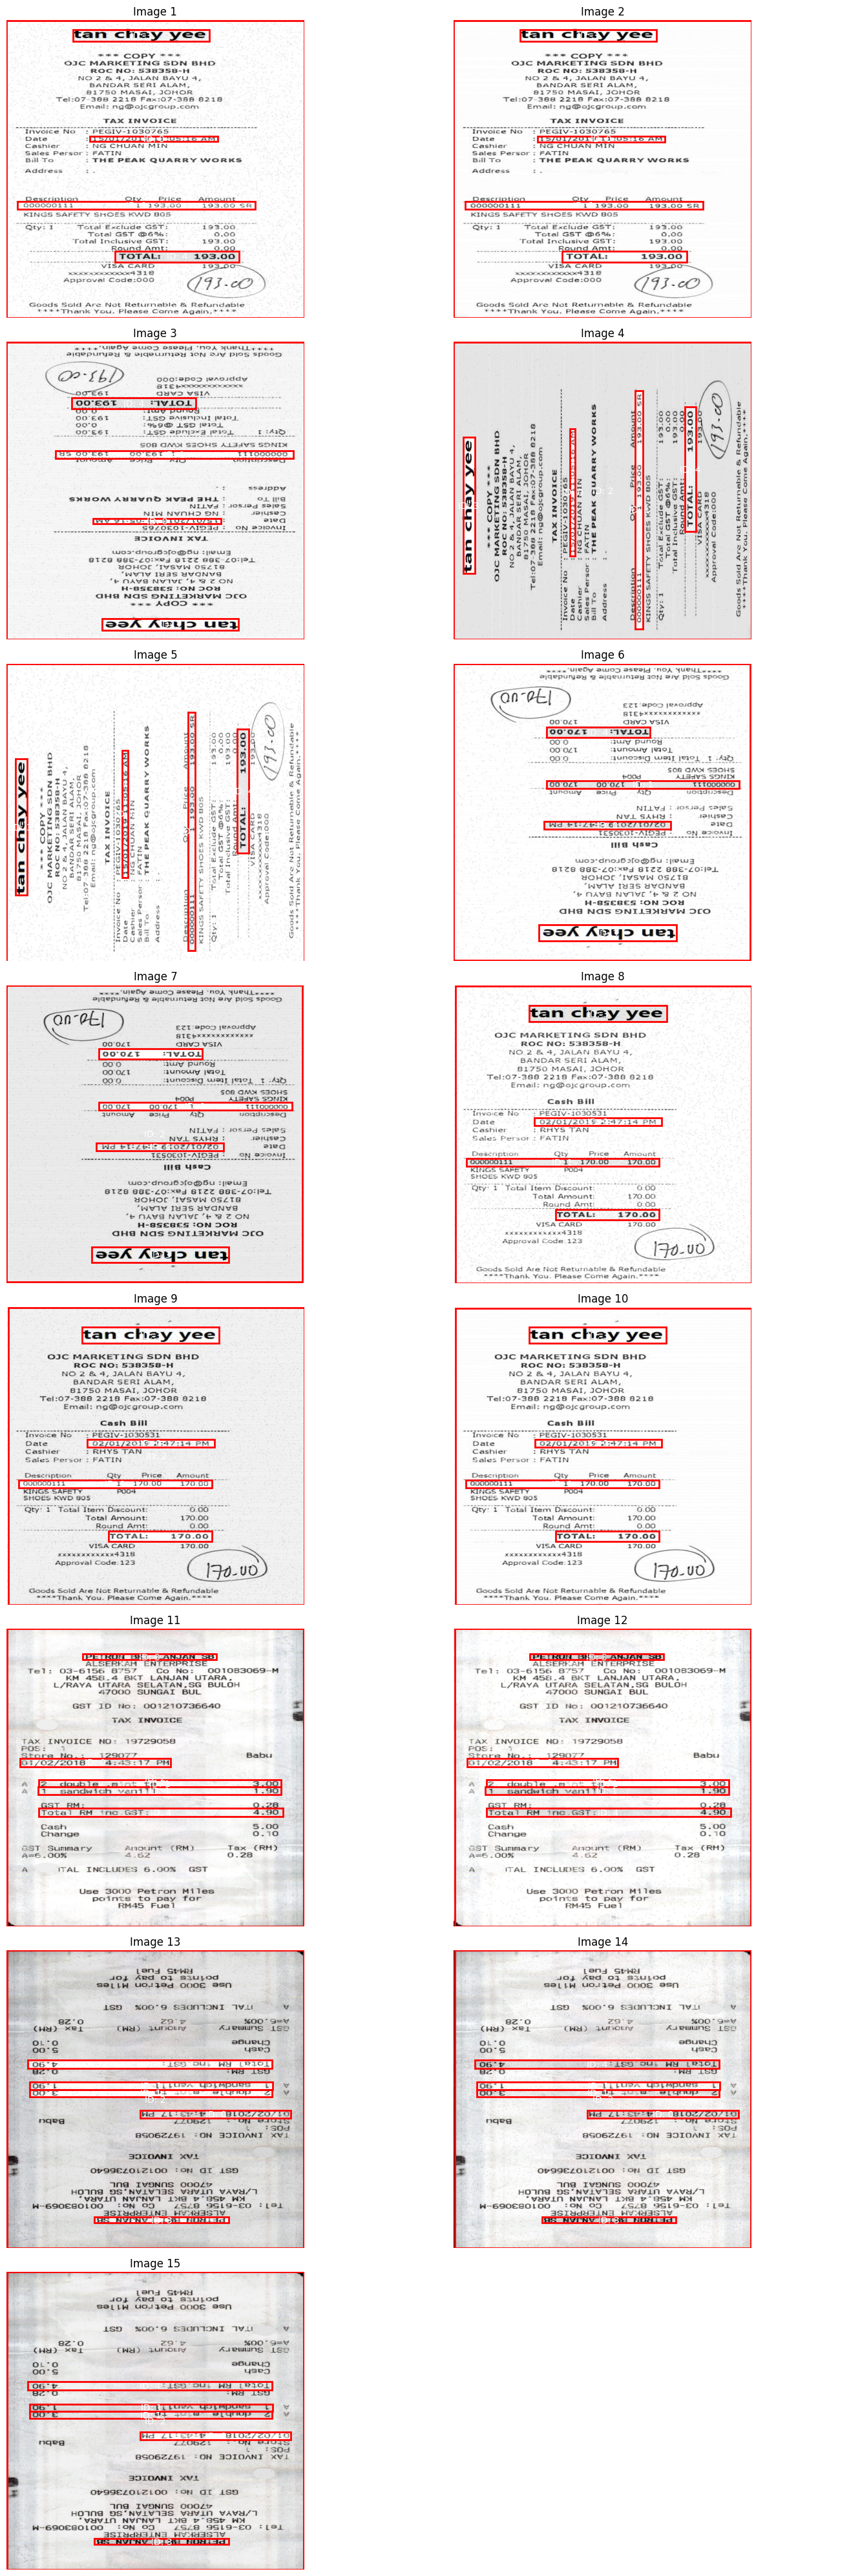

In [6]:
def unnormalized_anno(annotations, file_size):
        img_width, img_height = file_size
        
        unnormalized_annotations = []

        for anno in annotations:
                category_id, x_center, y_center, width, height = anno

                x_center_pixel = x_center * img_width
                y_center_pixel = y_center * img_height
                width_pixel = width * img_width
                height_pixel = height * img_height

                unnormalized_anno = (
                        category_id,
                        x_center_pixel,
                        y_center_pixel,
                        width_pixel,
                        height_pixel
                )

                unnormalized_annotations.append(unnormalized_anno)

        return unnormalized_annotations

def plot_data_anno(images, total):
        """
        Plot images with annotations drawn on them.

        :param images: List of dictionaries, each containing image file path and annotations.
        :param total: Number of images to plot.
        """
        # Define the number of images per row (2 images per row)
        images_per_row = 2
        rows = (total + images_per_row - 1) // images_per_row  # Calculate the number of rows

        # Create a figure to hold the plots
        fig, axes = plt.subplots(rows, images_per_row, figsize=(15, 5 * rows))

        # If there is only one row or a single image, make sure axes is iterable
        if total == 1:
                axes = [axes]
        elif rows == 1:
                axes = axes.tolist()

        # Loop through images and annotations
        for i, img_data in enumerate(images[:total]):
        # Get the image path, annotations, and size
                image_path = img_data['file_path']
                annotations = img_data['annotations']
                img = Image.open(image_path)

                # Find the row and column in the grid
                row = i // images_per_row
                col = i % images_per_row

                # Plot the image
                axes[row][col].imshow(img)
                axes[row][col].axis('off')  # Hide axes for better visualization
                axes[row][col].set_title(f"Image {i+1}")

                # Convert normalized annotations to pixel values
                normal_anno = unnormalized_anno(annotations, img_data['size'])

                # Loop through annotations and draw bounding boxes
                for anno in normal_anno:
                        category_id, x_center, y_center, width, height = anno

                        # Create a Rectangle patch with the unnormalized pixel values
                        rect = patches.Rectangle(
                        (x_center - width / 2, y_center - height / 2),
                        width, height,
                        linewidth=2, edgecolor='r', facecolor='none'
                        )

                        # Add the rectangle to the plot
                        axes[row][col].add_patch(rect)

                        # Optionally, you can also add the category_id as text
                        axes[row][col].text(
                        x_center, y_center, 
                        f"ID: {category_id}", color='white', fontsize=10,
                        ha='center', va='center'
                        )

                # Remove unused axes if there are fewer images than the grid space
                for i in range(total, rows * images_per_row):
                        row = i // images_per_row
                        col = i % images_per_row
                        axes[row][col].axis('off')  # Hide unused axes

        # Display the plot
        plt.tight_layout()
        plt.show()


plot_data_anno(images, 15)

In [ ]:

model = YOLO("yolo11n.pt")
# Train the model
results = model.train(data=ANNOTATION_PATH,
                epochs=100,
                imgsz=640,
                name="receipt_model",
                project="runs/train"
                )

NameError: name 'ANNOTATION_PATH' is not defined

In [ ]:
BEST_WEIGHT_PATH = ""

In [ ]:
model = YOLO(BEST_WEIGHT_PATH)

#TEST IMAGES LATER ON PROGRESS

results = model()

results[0].show()